# Topic 2: Recommendation System
### Gemsim, Cosin Similarity

In [1]:
!pip install gensim


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.4 MB 81.9 kB/s eta 0:04:58
     ---------------------------------------- 0.0/24.4 MB 81.9 kB/s eta 0:04:58
     ---------------------------------------- 0.0/24.4 MB 81.9 kB/s eta 0:04:58
     ---------------------------------------- 0.0/24.4 MB 81.9 kB/s eta 0:04:58
     ---------------------------------------- 0.0/24.4 MB 81.9 kB/s eta 0:04:58
     ---------------------------------------- 0.0/24.4 MB 81.9 kB/s eta 0:04:58
     ----------

In [2]:
!pip install pyvi

     ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.5 MB 991.0 kB/s eta 0:00:09
      --------------------------------------- 0.2/8.5 MB 2.5 MB/s eta 0:00:04
     -- ------------------------------------- 0.5/8.5 MB 3.7 MB/s eta 0:00:03
     ---- ----------------------------------- 1.0/8.5 MB 5.3 MB/s eta 0:00:02
     ------ --------------------------------- 1.4/8.5 MB 5.5 MB/s eta 0:00:02
     ------ --------------------------------- 1.4/8.5 MB 5.5 MB/s eta 0:00:02
     ------ --------------------------------- 1.4/8.5 MB 5.5 MB/s eta 0:00:02
     ----------- ---------------------------- 2.4/8.5 MB 6.0 MB/s eta 0:00:02
     ------------- -------------------------- 2.9/8.5 MB 6.1 MB/s eta 0:00:01
     --------------- ------------------------ 3.2/8.5 MB 6.2 MB/s eta 0:00:01
     --------------- ------------------------ 3.4/8.5 MB 5.8 MB/s eta 0:00:01
     ------------------ --------------------- 3.8/8.5 MB 6.1 MB/s eta


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from pyvi import ViTokenizer

s = "Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco..."
print(ViTokenizer.tokenize(s))

Bán xe # Vespa Sprint 125cc . Mua mới tại # Topco ...


In [3]:
# Note: Có thể tùy chọn các thư việc xử lý tiếng Việt

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from pyvi import ViTokenizer
# from underthesea import word_tokenize, pos_tag, sent_tokenize
from pyvi.ViTokenizer import tokenize
import warnings
from gensim import corpora, models, similarities
import re

In [154]:
# Hàm tiền xử lý dữ liệu
### Các bước bao gồm: chuyển chữ thường -> loại bỏ ký tự đặc biệt, dấu câu -> tách từ (tokenization) -> loại bỏ stopword
def text_preprocess(text):
    text = text.lower() # chuyển sang chữ thường
    for k, v in teencode_dict.items():
        text = re.sub(rf"\b{k}\b", v, text)
    text = re.sub(r"[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡ"
                  r"ùúụủũưừứựửữỳýỵỷỹđ\s]", " ", text) # bỏ ký tự đặc biệt, dấu câu
    #text = re.sub(r"\b(" + "|".join(map(re.escape, stop_words)) + r")\b", " ", text) # loại bỏ stopword trước khi tokenize
    text = re.sub(r"\s+", " ", text).strip() # chuẩn hóa khoảng trắng 
    
    tokens = ViTokenizer.tokenize(text).split() # tokenize - tách từ
    tokens = [t for t in tokens if t not in stop_words] # loại bỏ stopword sau khi tokenize: 
    clean_text = " ".join(tokens)
    return clean_text

In [155]:
STOP_WORD_FILE = './files/vietnamese-stopwords.txt'

In [156]:
stop_words =[]
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip() # loại bỏ khoảng trắng và ký tự xuống dòng
    if word:
           stop_words.append(word)

In [157]:
# theo demo của cô
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [158]:
TEENCODE_FILE = './files/teencode.txt'

In [159]:
# đọc file teen code và tạo teencode_dict {teencode: từ đầy đủ)
teencode_dict={}

with open(TEENCODE_FILE, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip() # bỏ dòng trống hoặc xuống dòng
        if not line:
            continue

        # tách theo tab
        parts = line.split("\t")
        if len(parts) ==2:
            slang, normal = parts
            teencode_dict[slang.strip()] = normal.strip()

In [160]:
# Đọc file excel abc.xlsx
df = pd.read_excel('./Data/data_motobikes.xlsx')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7208 entries, 0 to 7207
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   7208 non-null   int64 
 1   Tiêu đề              7207 non-null   object
 2   Giá                  7206 non-null   object
 3   Khoảng giá min       7006 non-null   object
 4   Khoảng giá max       7011 non-null   object
 5   Địa chỉ              7167 non-null   object
 6   Mô tả chi tiết       7208 non-null   object
 7   Thương hiệu          7205 non-null   object
 8   Dòng xe              7205 non-null   object
 9   Năm đăng ký          7208 non-null   object
 10  Số Km đã đi          7208 non-null   int64 
 11  Tình trạng           7208 non-null   object
 12  Loại xe              7208 non-null   object
 13  Dung tích xe         7208 non-null   object
 14  Xuất xứ              7208 non-null   object
 15  Chính sách bảo hành  7207 non-null   object
 16  Trọng 

In [162]:
df.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp 95%",66.000.000 đ,72.53 tr,85.14 tr,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh","Bán xe #Vespa Sprint 125cc. Mua mới tại #Topcom 01/2024, Xe chính chủ. Chạy được 14.000km. Giá: 66tr(TL). Anh/chị quan tâm nhắn Zalo số: ***. Công chứng Hợp đồng mua bán trong ngày.",Piaggio,Vespa,2024,14000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125109338.htm
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.500.000 đ,62.76 tr,73.68 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team Xám Xi Măng.\n_Xe nhà sử dụng kỹ ít đi, chính chủ, biển số thành phố\n_Xe mới keng, Máy móc nguyên zin, êm bốc, ae qua xe xem test thoải mái\n_Mua bán tại nhà, sang tên ký giấy 1 nốt nhạc\n_Xem Xe Tại Nhà Tân Sơn Nhì, P Tân Sơn Nhì , Q Tân Phú",Honda,SH,2019,28000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/124979025.htm
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.000.000 đ,28 tr,32.86 tr,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh","Chính chủ bán Vision phiên bản Thể Thao 2023 Đen\nXe mua chính hãng tháng 10/2023, bảo dưỡng đầy đủ, xe gia đình đi giữ gìn.\nXe đã độ lên đèn Demi led audi A7 và Đèn hậu led audi A7 (giá thị trường 5tr)\n(còn nguyên đèn mới zin theo xe)\nLiên hệ chính chủ 09xau xau 5 7 năm 3 sáu 7",Honda,Vision,2023,12000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125168772.htm
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH CHỦ,45.000.000 đ,43.1 tr,50.6 tr,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh","XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH CHỦ.\nChi Tiết hình ảnh xe đã có đủ. Cần thì liên hệ em.\nSản phẩm theo xe zin còn ( Kính, Bao tay, cảng sau, Chìa khóa còn đủ )\nCÓ FIX THÊM CHO ANH CHỊ VỀ SƠN DẬM LẠI.\nXem xe chi tiết Quận 1.\nliên hệ trao đổi qua GIÀLÔ: Không 933940 bốn ba hai.",Piaggio,Vespa,2019,60000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125127815.htm
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.000.000 đ,17.02 tr,19.98 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yamaha Latte 125, máy mạnh, tiết kiệm xăng.\n\nMàu đen nhám phối yên nâu.\n\nXe thuộc phiên bản cao cấp có hệ thống Stop & Start System, giúp tiết kiệm nhiên liệu và giảm khí thải.\n\nOdo hiện tại hơn 24.000 km – bảo dưỡng đều, máy móc vẫn rất ổn định.\n\nĐăng ký lần đầu: tháng 3/2021\n\nMáy zin, đề nhạy, vận hành êm\n\nCốp xe rộng, tiện để nón, túi xách\n\nBánh còn tốt, phanh an toàn, đèn đóm đầy đủ\n\n📍 Quận 1, TP.HCM, xem xe trực tiếp tại nhà theo hẹn\n💰 Giá bán: 23 triệu",Yamaha,Latte,2021,24000,Đã sử dụng,Tay ga,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125108206.htm


In [163]:
# Kiểm tra duplicates
df.duplicated().sum()

np.int64(0)

In [164]:
# cột giá đang hiểu là dạng object => chuyển sang numeric
# Chuyển đổi kiểu dữ liệu cột 'Giá', 'Khoảng giá min', 'Khoảng giá max' từ object sang float với đơn vị triệu đồng
df['Giá'] = (df['Giá'].str.replace(" đ","",regex=False).str.replace(".","",regex=False).astype(float)) / 1000000
#df['Khoảng giá min'] = (df['Khoảng giá min'].str.replace(" tr","",regex=False).astype(float))
#df['Khoảng giá max'] = (df['Khoảng giá max'].str.replace(" tr","",regex=False).astype(float))

In [165]:
# đổi số liệu năm đăng ký sang kiểu số
# chuyển đổi dữ liệu cột năm đăng ký sang số
df['Năm đăng ký'] = pd.to_numeric(df['Năm đăng ký'], errors='coerce')
df['Năm đăng ký'] = df['Năm đăng ký'].fillna(df['Năm đăng ký'].median())

In [166]:
# Tạo nội dung tổng hợp
# Lựa chọn các thông tin cần thiết để đưa vào phần content (giúp đề xuất nội dung)
# Có thể 1 cột hoặc nhiều cột thông tin
# ví dụ ở đây là chọn 1 cột, và chỉ lấy 200 từ đầu tiên trong phần mô tả (dễ quan sát khi làm demo)
df['Content'] = df[['Dòng xe','Loại xe','Dung tích xe','Mô tả chi tiết']].apply(lambda x: ' '.join([str(i) for i in x if pd.notnull(i)]), axis = 1)

In [167]:
df.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href,Content
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp 95%",66.0,72.53 tr,85.14 tr,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh","Bán xe #Vespa Sprint 125cc. Mua mới tại #Topcom 01/2024, Xe chính chủ. Chạy được 14.000km. Giá: 66tr(TL). Anh/chị quan tâm nhắn Zalo số: ***. Công chứng Hợp đồng mua bán trong ngày.",Piaggio,Vespa,2024.0,14000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125109338.htm,"Vespa Tay ga 100 - 175 cc Bán xe #Vespa Sprint 125cc. Mua mới tại #Topcom 01/2024, Xe chính chủ. Chạy được 14.000km. Giá: 66tr(TL). Anh/chị quan tâm nhắn Zalo số: ***. Công chứng Hợp đồng mua bán trong ngày."
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.5,62.76 tr,73.68 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team Xám Xi Măng.\n_Xe nhà sử dụng kỹ ít đi, chính chủ, biển số thành phố\n_Xe mới keng, Máy móc nguyên zin, êm bốc, ae qua xe xem test thoải mái\n_Mua bán tại nhà, sang tên ký giấy 1 nốt nhạc\n_Xem Xe Tại Nhà Tân Sơn Nhì, P Tân Sơn Nhì , Q Tân Phú",Honda,SH,2019.0,28000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/124979025.htm,"SH Tay ga 100 - 175 cc _Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team Xám Xi Măng.\n_Xe nhà sử dụng kỹ ít đi, chính chủ, biển số thành phố\n_Xe mới keng, Máy móc nguyên zin, êm bốc, ae qua xe xem test thoải mái\n_Mua bán tại nhà, sang tên ký giấy 1 nốt nhạc\n_Xem Xe Tại Nhà Tân Sơn Nhì, P Tân Sơn Nhì , Q Tân Phú"
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.0,28 tr,32.86 tr,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh","Chính chủ bán Vision phiên bản Thể Thao 2023 Đen\nXe mua chính hãng tháng 10/2023, bảo dưỡng đầy đủ, xe gia đình đi giữ gìn.\nXe đã độ lên đèn Demi led audi A7 và Đèn hậu led audi A7 (giá thị trường 5tr)\n(còn nguyên đèn mới zin theo xe)\nLiên hệ chính chủ 09xau xau 5 7 năm 3 sáu 7",Honda,Vision,2023.0,12000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125168772.htm,"Vision Tay ga 100 - 175 cc Chính chủ bán Vision phiên bản Thể Thao 2023 Đen\nXe mua chính hãng tháng 10/2023, bảo dưỡng đầy đủ, xe gia đình đi giữ gìn.\nXe đã độ lên đèn Demi led audi A7 và Đèn hậu led audi A7 (giá thị trường 5tr)\n(còn nguyên đèn mới zin theo xe)\nLiên hệ chính chủ 09xau xau 5 7 năm 3 sáu 7"
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH CHỦ,45.0,43.1 tr,50.6 tr,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh","XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH CHỦ.\nChi Tiết hình ảnh xe đã có đủ. Cần thì liên hệ em.\nSản phẩm theo xe zin còn ( Kính, Bao tay, cảng sau, Chìa khóa còn đủ )\nCÓ FIX THÊM CHO ANH CHỊ VỀ SƠN DẬM LẠI.\nXem xe chi tiết Quận 1.\nliên hệ trao đổi qua GIÀLÔ: Không 933940 bốn ba hai.",Piaggio,Vespa,2019.0,60000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp-ho-chi-minh/125127815.htm,"Vespa Tay ga 100 - 175 cc XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH CHỦ.\nChi Tiết hình ảnh xe đã có đủ. Cần thì liên hệ em.\nSản phẩm theo xe zin còn ( Kính, Bao tay, cảng sau, Chìa khóa còn đủ )\nCÓ FIX THÊM CHO ANH CHỊ VỀ SƠN DẬM LẠI.\nXem xe chi tiết Quận 1.\nliên hệ trao đổi qua GIÀLÔ: Không 933940 bốn ba hai."
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.0,17.02 tr,19.98 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yamaha Latte 125, máy mạnh, tiết kiệm xăng.\n\nMàu đen nhám phối yên nâu.\n\nXe thuộc phiên bản cao cấp có hệ thống Stop & Start System, giúp tiết kiệm nhiên liệu và giảm khí thải.\n\nOdo hiện tại hơn 24.000 km – bảo dưỡng đều, máy móc vẫn rất ổn đị

In [168]:
# Làm sạch dữ liệu
df["Content_wt"]=df["Content"].apply(lambda x: text_preprocess(x))

### Save và load file dữ liệu sau word tokenize

In [173]:
# Xuất ra file csv sau khi đã làm sạch dữ liệu 
df.to_csv("./Data/cho_tot_cleaned_wt.csv", index=False)

In [ ]:
# Đọc file excel abc.xlsx
df = pd.read_excel('./Data/data_motobikes.xlsx')

In [169]:
# word_tokenize: đã đưa vào function làm sạch
# df["Content_wt"]=df["Content"].apply(lambda x: tokenize(x))

In [170]:
pd.set_option('display.max_colwidth', None)

df[["Content", "Content_wt"]].head(5)

,Content,Content_wt
0,"Vespa Tay ga 100 - 175 cc Bán xe #Vespa Sprint 125cc. Mua mới tại #Topcom 01/2024, Xe chính chủ. Chạy được 14.000km. Giá: 66tr(TL). Anh/chị quan tâm nhắn Zalo số: ***. Công chứng Hợp đồng mua bán trong ngày.",vespa ga 100 175 cc vespa sprint 125cc topcom 01 2024 chủ chạy 14 000km giá 66tr thương_lượng anh_chị nhắn liên_hệ_số công_chứng hợp_đồng mua_bán
1,"SH Tay ga 100 - 175 cc _Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team Xám Xi Măng.\n_Xe nhà sử dụng kỹ ít đi, chính chủ, biển số thành phố\n_Xe mới keng, Máy móc nguyên zin, êm bốc, ae qua xe xem test thoải mái\n_Mua bán tại nhà, sang tên ký giấy 1 nốt nhạc\n_Xem Xe Tại Nhà Tân Sơn Nhì, P Tân Sơn Nhì , Q Tân Phú",sh ga 100 175 cc sh 150i thắng abs 2019 xám bạc úp team xám xi_măng kỹ chủ biển keng máy_móc nguyên nguyên êm bốc test thoải_mái mua_bán sang_tên ký giấy 1 nốt_nhạc tân sơn nhì phường tân sơn nhì tân_phú
2,"Vision Tay ga 100 - 175 cc Chính chủ bán Vision phiên bản Thể Thao 2023 Đen\nXe mua chính hãng tháng 10/2023, bảo dưỡng đầy đủ, xe gia đình đi giữ gìn.\nXe đã độ lên đèn Demi led audi A7 và Đèn hậu led audi A7 (giá thị trường 5tr)\n(còn nguyên đèn mới zin theo xe)\nLiên hệ chính chủ 09xau xau 5 7 năm 3 sáu 7",vision ga 100 175 cc chủ vision phiên_bản thể_thao 2023 đen hãng 10 2023 bảo_dưỡng đầy_đủ gia_đình giữ_gìn độ lên_đèn demi led audi a7 đèn hậu led audi a7 giá thị_trường 5tr nguyên đèn nguyên liên_hệ chủ 09xau xau 5 7 3 sáu 7
3,"Vespa Tay ga 100 - 175 cc XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH CHỦ.\nChi Tiết hình ảnh xe đã có đủ. Cần thì liên hệ em.\nSản phẩm theo xe zin còn ( Kính, Bao tay, cảng sau, Chìa khóa còn đủ )\nCÓ FIX THÊM CHO ANH CHỊ VỀ SƠN DẬM LẠI.\nXem xe chi tiết Quận 1.\nliên hệ trao đổi qua GIÀLÔ: Không 933940 bốn ba hai.",vespa ga 100 175 cc xe_ca nhân n đư chi nh chu chi tiê t hi nh nh đa co đu câ n thi liên hê sa n phâ m nguyên co n ki nh bao_tay ca chi kho co n đu co fix chi vê sơn dâ m la chi tiê t quâ n 1 liên hê trao đô gia lô không 933940 bô n hai
4,"Latte Tay ga 100 - 175 cc 🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yamaha Latte 125, máy mạnh, tiết kiệm xăng.\n\nMàu đen nhám phối yên nâu.\n\nXe thuộc phiên bản cao cấp có hệ thống Stop & Start System, giúp tiết kiệm nhiên liệu và giảm khí thải.\n\nOdo hiện tại hơn 24.000 km – bảo dưỡng đều, máy móc vẫn rất ổn định.\n\nĐăng ký lần đầu: tháng 3/2021\n\nMáy zin, đề nhạy, vận hành êm\n\nCốp xe rộng, tiện để nón, túi xách\n\nBánh còn tốt, phanh an toàn, đèn đóm đầy đủ\n\n📍 Quận 1, TP.HCM, xem xe trực tiếp tại nhà theo hẹn\n💰 Giá bán: 23 triệu",latte ga 100 175 cc thông_tin dòng ga cao_cấp yamaha latte 125 máy tiết_kiệm xăng màu đen nhám phối yên nâu phiên_bản cao_cấp hệ_thống stop start system giúp tiết_kiệm nhiên_liệu khí_thải odo 24 000 km bảo_dưỡng máy_móc ổn_định đăng_ký đầu 3 2021 máy nguyên đề nhạy vận_hành êm cốp rộng tiện nón túi_xách bánh tốt phanh an_toàn đèn_đóm đầy_đủ 1 hồ chí minh hồ chí minh hẹn giá 23 triệu


In [171]:
# Từ phổ biến nhất
from collections import Counter
all_words = ' '.join(df['Content_wt']).split()
word_counts = Counter(all_words)
common_words = pd.DataFrame(word_counts.most_common(30), columns=['word', 'count'])
common_words

,word,count
0,cc,7207
1,100,6793
2,175,6175
3,nguyên,4130
4,ga,3876
5,không,3306
6,chủ,3013
7,chạy,2293
8,máy,2293
9,biển,2258


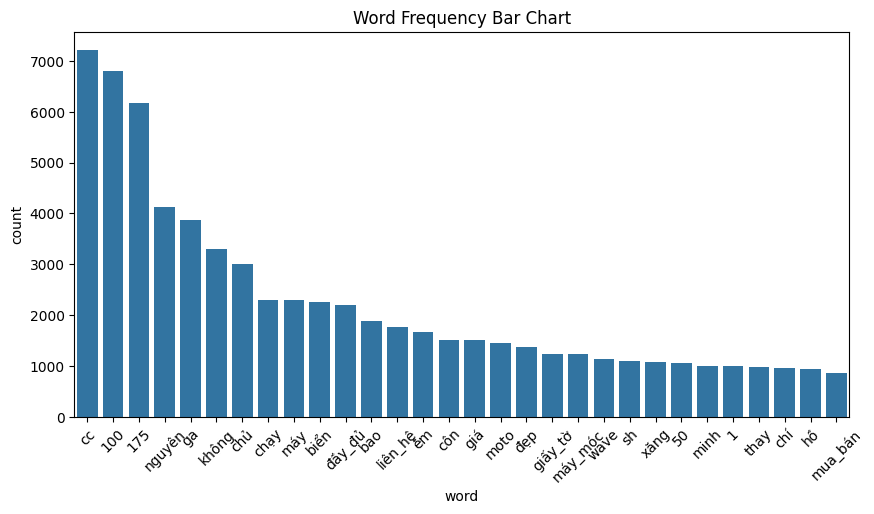

In [172]:
# Vẽ biểu đồ từ
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(data=common_words, x='word', y='count')
plt.xticks(rotation=45)
plt.title("Word Frequency Bar Chart")
plt.show()

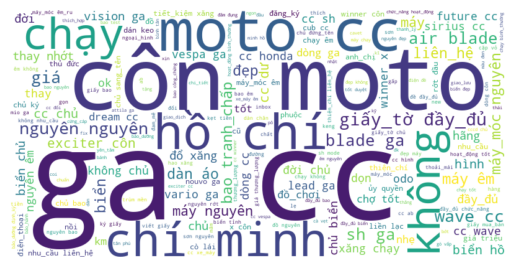

In [22]:
from wordcloud import WordCloud
text = " ".join(df['Content_wt'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Kiểm tra common word và wordcloud, cập nhật stopword và teencode:
- Cập nhật các stopword vào file stopword: xe, đi, anh, chị, em, mua, bán, nha, thành phố hồ chí minh, 
- cập nhật danh sách teencode vào file txt: zin nguyên, bstp biển số thành phố, tl thương lượng, full đầy đủ, GIÀLÔ liên hệ, alo liên hệ, lh liên hệ, tp hcm thành phố hồ chí minh, tp thành phố hồ chí minh, p phường, q quận

In [174]:
import re

# Cosine_similarity
- link https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- link https://en.wikipedia.org/wiki/Cosine_similarity
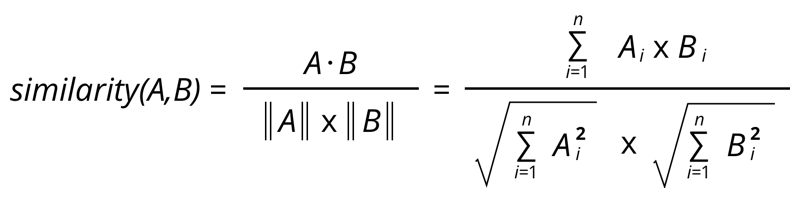

In [118]:
from numpy import dot
from numpy.linalg import norm
A = [1,2]
B = [2,2]
cos_sim = dot(A,B) / (norm(A)*norm(B))
print(cos_sim)

0.9486832980505138


In [256]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import time

# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Content_wt'])
t0 = time.time()
# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

t1 = time.time()
time_cosine = t1 - t0
print("fit_time cosine", t1-t0)

fit_time cosine 1.359588623046875


In [176]:
df_show = pd.DataFrame(cosine_sim)
df_show

,0,1,2,3,4,5,6,7,8,9,...,7198,7199,7200,7201,7202,7203,7204,7205,7206,7207
0,1.000000,0.023984,0.021556,0.026243,0.013057,0.015542,0.047748,0.025439,0.044641,0.062371,...,0.037710,0.008101,0.063030,0.017986,0.133658,0.141971,0.011702,0.066500,0.044612,0.001672
1,0.023984,1.000000,0.022856,0.020916,0.018770,0.001772,0.010609,0.038055,0.018851,0.092459,...,0.089538,0.084735,0.151277,0.005148,0.012381,0.047693,0.060011,0.057805,0.038438,0.048219
2,0.021556,0.022856,1.000000,0.005629,0.051415,0.001529,0.009158,0.016744,0.038147,0.044189,...,0.034977,0.033646,0.058770,0.031114,0.032867,0.063661,0.010250,0.026068,0.053685,0.025730
3,0.026243,0.020916,0.005629,1.000000,0.004098,0.009102,0.018470,0.011215,0.004621,0.044081,...,0.017173,0.016180,0.014125,0.002682,0.025131,0.013973,0.004684,0.005826,0.004549,0.002975
4,0.013057,0.018770,0.051415,0.004098,1.000000,0.029762,0.055701,0.025342,0.024201,0.044644,...,0.036378,0.047916,0.044175,0.036422,0.039564,0.023521,0.005224,0.133828,0.035497,0.019089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7203,0.141971,0.047693,0.063661,0.013973,0.023521,0.033982,0.031723,0.076905,0.143529,0.075544,...,0.071294,0.062479,0.103299,0.150157,0.073076,1.000000,0.025587,0.044160,0.077221,0.039767
7204,0.011702,0.060011,0.010250,0.004684,0.005224,0.016884,0.010252,0.002710,0.018217,0.084249,...,0.015741,0.001935,0.106272,0.019739,0.011964,0.025587,1.000000,0.067467,0.008290,0.003447
7205,0.066500,0.057805,0.026068,0.005826,0.133828,0.021001,0.012752,0.029387,0.101113,0.094754,...,0.044105,0.037637,0.137311,0.038839,0.120887,0.044160,0.067467,1.000000,0.040233,0.019948
7206,0.044612,0.038438,0.053685,0.004549,0.035497,0.082186,0.007897,0.037751,0.061450,0.058979,...,0.114820,0.037896,0.053122,0.100417,0.009216,0.077221,0.008290,0.040233,1.000000,0.039418


In [177]:
# Hàm đề xuất xe
# # với mỗi xe, lấy nums xe tương quan nhất
def get_recommendations(id, cosine_sim=cosine_sim, nums=5):
    # Lấy index của item đầu vào
    idx = df.index[df['id'] == id][0]
    # Tính similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    # sort giá trị giảm dần
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Lấp top và bỏ chính nó
    sim_scores = sim_scores[1:nums+1]  # Lấy 5 xe tương tự nhất
    # lấy danh sách index
    hotel_indices = [i[0] for i in sim_scores]
    # lấy danh sách similarity
    sim_values = [i[1] for i in sim_scores]
    # Tạo dataframe kết quả
    result = df[['id', 'Giá','Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt']].iloc[hotel_indices]
    result['similarity'] = sim_values
    return result

In [178]:
print(df[['id','Giá','Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết']].iloc[13])

id                                                                                                                                                                                                                     14
Giá                                                                                                                                                                                                                  18.5
Dòng xe                                                                                                                                                                                                           Exciter
Năm đăng ký                                                                                                                                                                                                        2014.0
Loại xe                                                                                                                         

In [179]:
# Gọi function get_recommendations(hàng thứ ???) ~ idx + 1
recommendations = get_recommendations(14)
recommendations.head(5)

,id,Giá,Dòng xe,Năm đăng ký,Loại xe,Dung tích xe,Mô tả chi tiết,Content_wt,similarity
6393,6394,11.0,Exciter,2014.0,Tay côn/Moto,100 - 175 cc,"Nhà ít đi cần bán xe ex 2014 , xe còn nguyên zin bstp.",exciter côn moto 100 175 cc ex 2014 nguyên nguyên biển,0.330442
3792,3793,17.0,Exciter,2017.0,Tay côn/Moto,100 - 175 cc,"chạy chán e bán hoặc đổi\nchiếc ex 2017 bs 83 k chính chủ máy êm chức năng đủ 16tr\nwinner x 2021 máy êm bs 81 giấy tờ dầyd đủ máy zin chưa rớt, êm ru áo có xấu tí giá 17tr \nđổi lấy AB 2022 trở lên hoặc vario bù trừ thương lượng \nhoặc cả 3 chiếc như hình AB 2015 êm ru máy zin chính chủ 15tr . và 2 chiếc kia\n đổi lấy SH 2021 trở lên bù trừ thương lượng trực tiếp\nyêu cầu tay ga zin êm ,chưa rớt máy , áo zin k độ chế , chính chủ 1 hoặc 2 chủ có thể rút gốc dc . \nthiện chí call hoặc inb zalo trao đổi thêm ạ",exciter côn moto 100 175 cc chạy chán đổi ex 2017 biển 83 không chủ máy êm chức_năng 16tr winner x 2021 máy êm biển 81 giấy_tờ dầyd máy nguyên rớt êm_ru áo xấu tí giá 17tr đổi ab 2022 trở vario bù_trừ thương_lượng 3 hình ab 2015 êm_ru máy nguyên chủ 15tr 2 kia đổi sh 2021 trở bù_trừ thương_lượng ga nguyên êm rớt máy áo nguyên không độ chế chủ 1 2 chủ rút gốc thiện_chí call inb liên_hệ trao_đổi,0.220554
3772,3773,20.5,Exciter,2013.0,Tay côn/Moto,100 - 175 cc,Do nhu cầu không sử dụng xe. Nên mình bán con ex 2013 gp. Xe còn mới 1 đời chủ. Đầu nồi chưa rớt. Ai cần xin liên hệ. Bớt lộc cho ae thiện chí,exciter côn moto 100 175 cc nhu_cầu không ex 2013 gp 1 đời chủ đầu nồi rớt liên_hệ bớt lộc thiện_chí,0.215979
4008,4009,12.0,Exciter,2016.0,Tay côn/Moto,100 - 175 cc,"Xe đã qua sử dụng, nguyên zin bao teat\n\nLiên hệ Trực tiếp Trao đổi",exciter côn moto 100 175 cc nguyên nguyên bao teat liên_hệ trao_đổi,0.196242
5548,5549,20.8,GSX,2018.0,Tay côn/Moto,100 - 175 cc,-Cần bán hoặc giao lưu Lead hoặc AB 2020 trở lên bù trừ,gsx côn moto 100 175 cc giao_lưu lead ab 2020 trở bù_trừ,0.194109


#### Lưu ma trận kết quả consin và đọc lên khi cần đề xuất

In [180]:
# Save cosine_sim to file
import pickle
with open('xe_cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Open and read file to cosine_sim_new
with open('xe_cosine_sim.pkl', 'rb') as f:
    cosine_sim_new = pickle.load(f)
# cosine_sim_new

In [181]:
def get_recommendations(df, id, cosine_sim=cosine_sim, nums=5):
    # Get the index of the motobikes that matches the hotel_id
    matching_indices = df.index[df['id'] == id].tolist()
    if not matching_indices:
        print(f"No bike found with ID: {id}")
        return pd.DataFrame()  # Return an empty DataFrame if no match
    idx = matching_indices[0]

    # Get the pairwise similarity scores of all bikes with that bike
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the bikes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar bikes (Ignoring the bike itself)
    sim_scores = sim_scores[1:nums+1]

    # Get the bike indices
    bike_indices = [i[0] for i in sim_scores]

    # Lấy danh sách similarity
    sim_values = [i[1] for i in sim_scores]

    # Tạo dataframe kết quả
    result = df.iloc[bike_indices]

    # thêm cột sinilarity
    result['similarity'] = sim_values

    # Return the top n most similar bikes as a DataFrame
    return result

In [182]:
# Example usage (make sure to use a valid hotel_id from your DataFrame)
recommendations = get_recommendations(df, 14, cosine_sim=cosine_sim_new, nums=5)
recommendations[['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt','similarity']].head(5)

C:\Users\iywnt\AppData\Local\Temp\ipykernel_4076\2951454326.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['similarity'] = sim_values


,id,Giá,Dòng xe,Năm đăng ký,Loại xe,Dung tích xe,Mô tả chi tiết,Content_wt,similarity
6393,6394,11.0,Exciter,2014.0,Tay côn/Moto,100 - 175 cc,"Nhà ít đi cần bán xe ex 2014 , xe còn nguyên zin bstp.",exciter côn moto 100 175 cc ex 2014 nguyên nguyên biển,0.330442
3792,3793,17.0,Exciter,2017.0,Tay côn/Moto,100 - 175 cc,"chạy chán e bán hoặc đổi\nchiếc ex 2017 bs 83 k chính chủ máy êm chức năng đủ 16tr\nwinner x 2021 máy êm bs 81 giấy tờ dầyd đủ máy zin chưa rớt, êm ru áo có xấu tí giá 17tr \nđổi lấy AB 2022 trở lên hoặc vario bù trừ thương lượng \nhoặc cả 3 chiếc như hình AB 2015 êm ru máy zin chính chủ 15tr . và 2 chiếc kia\n đổi lấy SH 2021 trở lên bù trừ thương lượng trực tiếp\nyêu cầu tay ga zin êm ,chưa rớt máy , áo zin k độ chế , chính chủ 1 hoặc 2 chủ có thể rút gốc dc . \nthiện chí call hoặc inb zalo trao đổi thêm ạ",exciter côn moto 100 175 cc chạy chán đổi ex 2017 biển 83 không chủ máy êm chức_năng 16tr winner x 2021 máy êm biển 81 giấy_tờ dầyd máy nguyên rớt êm_ru áo xấu tí giá 17tr đổi ab 2022 trở vario bù_trừ thương_lượng 3 hình ab 2015 êm_ru máy nguyên chủ 15tr 2 kia đổi sh 2021 trở bù_trừ thương_lượng ga nguyên êm rớt máy áo nguyên không độ chế chủ 1 2 chủ rút gốc thiện_chí call inb liên_hệ trao_đổi,0.220554
3772,3773,20.5,Exciter,2013.0,Tay côn/Moto,100 - 175 cc,Do nhu cầu không sử dụng xe. Nên mình bán con ex 2013 gp. Xe còn mới 1 đời chủ. Đầu nồi chưa rớt. Ai cần xin liên hệ. Bớt lộc cho ae thiện chí,exciter côn moto 100 175 cc nhu_cầu không ex 2013 gp 1 đời chủ đầu nồi rớt liên_hệ bớt lộc thiện_chí,0.215979
4008,4009,12.0,Exciter,2016.0,Tay côn/Moto,100 - 175 cc,"Xe đã qua sử dụng, nguyên zin bao teat\n\nLiên hệ Trực tiếp Trao đổi",exciter côn moto 100 175 cc nguyên nguyên bao teat liên_hệ trao_đổi,0.196242
5548,5549,20.8,GSX,2018.0,Tay côn/Moto,100 - 175 cc,-Cần bán hoặc giao lưu Lead hoặc AB 2020 trở lên bù trừ,gsx côn moto 100 175 cc giao_lưu lead ab 2020 trở bù_trừ,0.194109


# Gensim

In [183]:
# Tokenize(split) the sentences into words
content_gem = [[text for text in x.split()] for x in df.Content_wt]

In [184]:
len(content_gem)

7208

In [185]:
content_gem[:1]

[['vespa',
  'ga',
  '100',
  '175',
  'cc',
  'vespa',
  'sprint',
  '125cc',
  'topcom',
  '01',
  '2024',
  'chủ',
  'chạy',
  '14',
  '000km',
  'giá',
  '66tr',
  'thương_lượng',
  'anh_chị',
  'nhắn',
  'liên_hệ_số',
  'công_chứng',
  'hợp_đồng',
  'mua_bán']]

In [186]:
import re

In [187]:
# Tiền xử lý dữ liệu ===> đã thực hiện tiền xử lý bên trên nên không thực hiện tại đây
#content_gem_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '(', ')', '+', '/', "'", '&', '#', '*']] for text in  content_gem] # kiểm tra nội dung và đưa vào các ký tự đặc biệt
#content_gem_re = [[t for t in text if not t in stop_words] for text in content_gem_re] # stopword

# Thực hiện các tiền xử lý khác...
# Nên viết phần tiền xử lý này vào function để có thể tái sử dụng khi cần

In [188]:
content_gem[:1]
# Có thể đưa content_gem_re này thành 1 cột của df để không mất công xử lý nhiều lần

[['vespa',
  'ga',
  '100',
  '175',
  'cc',
  'vespa',
  'sprint',
  '125cc',
  'topcom',
  '01',
  '2024',
  'chủ',
  'chạy',
  '14',
  '000km',
  'giá',
  '66tr',
  'thương_lượng',
  'anh_chị',
  'nhắn',
  'liên_hệ_số',
  'công_chứng',
  'hợp_đồng',
  'mua_bán']]

In [189]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(content_gem)
# dictionary = corpora.Dictionary(content_gem_re) # code demo, do không thực hiện bước tiền xử lý nên vẫn sử dụng content_gem

In [190]:
# loại bỏ từ hiếm và từ quá phổ biến
# dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=500)


In [191]:
# List of features in dictionary
dictionary.token2id

{'000km': 0,
 '01': 1,
 '100': 2,
 '125cc': 3,
 '14': 4,
 '175': 5,
 '2024': 6,
 '66tr': 7,
 'anh_chị': 8,
 'cc': 9,
 'chạy': 10,
 'chủ': 11,
 'công_chứng': 12,
 'ga': 13,
 'giá': 14,
 'hợp_đồng': 15,
 'liên_hệ_số': 16,
 'mua_bán': 17,
 'nhắn': 18,
 'sprint': 19,
 'thương_lượng': 20,
 'topcom': 21,
 'vespa': 22,
 '1': 23,
 '150i': 24,
 '2019': 25,
 'abs': 26,
 'biển': 27,
 'bạc': 28,
 'bốc': 29,
 'giấy': 30,
 'keng': 31,
 'ký': 32,
 'kỹ': 33,
 'máy_móc': 34,
 'nguyên': 35,
 'nhì': 36,
 'nốt_nhạc': 37,
 'phường': 38,
 'sang_tên': 39,
 'sh': 40,
 'sơn': 41,
 'team': 42,
 'test': 43,
 'thoải_mái': 44,
 'thắng': 45,
 'tân': 46,
 'tân_phú': 47,
 'xi_măng': 48,
 'xám': 49,
 'êm': 50,
 'úp': 51,
 '09xau': 52,
 '10': 53,
 '2023': 54,
 '3': 55,
 '5': 56,
 '5tr': 57,
 '7': 58,
 'a7': 59,
 'audi': 60,
 'bảo_dưỡng': 61,
 'demi': 62,
 'gia_đình': 63,
 'giữ_gìn': 64,
 'hãng': 65,
 'hậu': 66,
 'led': 67,
 'liên_hệ': 68,
 'lên_đèn': 69,
 'phiên_bản': 70,
 'sáu': 71,
 'thể_thao': 72,
 'thị_trường': 73,

In [192]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

In [193]:
feature_cnt

9371

In [194]:
# Obtain corpus based on dictionary (dense matrix)
#corpus = [dictionary.doc2bow(text) for text in content_gem_re]
corpus = [dictionary.doc2bow(text) for text in content_gem]

In [195]:
corpus[1] # id, so lan xuat hien cua token trong van ban/ san pham

[(2, 1),
 (5, 1),
 (9, 1),
 (11, 1),
 (13, 1),
 (17, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 2),
 (36, 2),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 2),
 (41, 2),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 2),
 (47, 1),
 (48, 1),
 (49, 2),
 (50, 1),
 (51, 1)]

In [196]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 2)]

In [261]:
# Use TF-IDF Model to process corpus, obtaining index

tfidf = models.TfidfModel(corpus)
t0 = time.time()
# tính toán sự tương tự trong ma trận thưa thớt
gen_sim = similarities.SparseMatrixSimilarity(tfidf[corpus],
                                            num_features = feature_cnt)
# ma tran: n x n
t1 = time.time()
time_gen = t1-t0
print("fit_time gensim", t1-t0)

fit_time gensim 0.32329559326171875


In [198]:
df_1 = pd.DataFrame(gen_sim)
df_1

,0,1,2,3,4,5,6,7,8,9,...,7198,7199,7200,7201,7202,7203,7204,7205,7206,7207
0,1.000000,0.010637,0.007071,0.015760,0.004054,6.430410e-03,0.029765,0.011220,0.015054,0.041766,...,0.019679,0.002961,0.039884,0.005358,0.090068,0.107411,0.002280,0.039638,0.021274,0.000024
1,0.010637,1.000000,0.006851,0.013480,0.011046,1.205304e-02,0.001245,0.029274,0.004031,0.054627,...,0.044471,0.060341,0.113205,0.000070,0.013745,0.015064,0.052100,0.035897,0.018724,0.038138
2,0.007071,0.006851,1.000000,0.001111,0.043539,1.781784e-07,0.001001,0.007229,0.013261,0.019599,...,0.010516,0.012522,0.022117,0.018261,0.011618,0.022829,0.002281,0.009010,0.029598,0.014156
3,0.015760,0.013480,0.001111,1.000000,0.002311,7.833132e-03,0.009515,0.006274,0.000054,0.026832,...,0.004383,0.007647,0.003453,0.000029,0.017972,0.002696,0.005286,0.001144,0.000770,0.000720
4,0.004054,0.011046,0.043539,0.002311,1.000000,2.872861e-02,0.042159,0.012378,0.008589,0.023446,...,0.015523,0.027177,0.021904,0.026298,0.026897,0.005459,0.007698,0.090982,0.020287,0.012294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7203,0.107411,0.015064,0.022829,0.002696,0.005459,1.574348e-02,0.004113,0.038832,0.065153,0.028465,...,0.021776,0.026908,0.037634,0.093325,0.023787,1.000000,0.005582,0.012786,0.031709,0.024248
7204,0.002280,0.052100,0.002281,0.005286,0.007698,2.791197e-02,0.001131,0.000014,0.003661,0.061012,...,0.003597,0.000024,0.083731,0.009887,0.023809,0.005582,1.000000,0.044746,0.001565,0.000854
7205,0.039638,0.035897,0.009010,0.001144,0.090982,8.210501e-03,0.001543,0.013298,0.064885,0.063572,...,0.022852,0.026259,0.104995,0.029549,0.087249,0.012786,0.044746,1.000000,0.020710,0.015745
7206,0.021274,0.018724,0.029598,0.000770,0.020287,5.406009e-02,0.000115,0.019066,0.024134,0.029181,...,0.068821,0.016482,0.021421,0.073761,0.000117,0.031709,0.001565,0.020710,1.000000,0.027773


In [199]:
# Trường hợp khách chọn 1 xe để xem thông tin
# Giả sử là chọn xe đầu tiên với id = 1
# giả sử bạn đã có DataFrame df_1

In [200]:
# giả sử df_1 là ma trận tương đồng n×n, index và columns đều là chỉ số/ID
id = 14
# tìm index trong DF gốc
idx = df.index[df['id'] == id][0]
# lấy similarity vector của dòng đó
row = df_1.loc[idx]
# lấy top 5 và bỏ chính nó
top5 = row.drop(idx, errors='ignore').nlargest(5)   # bỏ chính nó
# lấy index của top 5
top5_indices = top5.index.tolist()                 # <-- lấy index của Series
# lấy giá trị similarity tương ứng từ df_1
sim_values = df_1.loc[idx, top5_indices].values
# lấy kết quả
result = df.iloc[top5_indices]
result['gen_similarity'] = sim_values
print(top5_indices)                               # [chỉ số các item tương tự nhất]

[6393, 3772, 3792, 5548, 6458]


C:\Users\iywnt\AppData\Local\Temp\ipykernel_4076\575776316.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['gen_similarity'] = sim_values


In [201]:
result[['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt', 'gen_similarity']].head(2)

,id,Giá,Dòng xe,Năm đăng ký,Loại xe,Dung tích xe,Mô tả chi tiết,Content_wt,gen_similarity
6393,6394,11.0,Exciter,2014.0,Tay côn/Moto,100 - 175 cc,"Nhà ít đi cần bán xe ex 2014 , xe còn nguyên zin bstp.",exciter côn moto 100 175 cc ex 2014 nguyên nguyên biển,0.28150
3772,3773,20.5,Exciter,2013.0,Tay côn/Moto,100 - 175 cc,Do nhu cầu không sử dụng xe. Nên mình bán con ex 2013 gp. Xe còn mới 1 đời chủ. Đầu nồi chưa rớt. Ai cần xin liên hệ. Bớt lộc cho ae thiện chí,exciter côn moto 100 175 cc nhu_cầu không ex 2013 gp 1 đời chủ đầu nồi rớt liên_hệ bớt lộc thiện_chí,0.19336


In [202]:
df.iloc[top5_indices]

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href,Content,Content_wt
6393,6394,Ex 2014 máy móc nguyen zin,11.0,13.61 tr,15.98 tr,"Xã Vĩnh Lộc A, Huyện Bình Chánh, Tp Hồ Chí Minh","Nhà ít đi cần bán xe ex 2014 , xe còn nguyên zin bstp.",Yamaha,Exciter,2014.0,99999,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-huyen-binh-chanh-tp-ho-chi-minh/123348326.htm,"Exciter Tay côn/Moto 100 - 175 cc Nhà ít đi cần bán xe ex 2014 , xe còn nguyên zin bstp.",exciter côn moto 100 175 cc ex 2014 nguyên nguyên biển
3772,3773,bán ex 2013 1 đời chủ,20.5,14.53 tr,17.05 tr,"Phường 6, Quận Gò Vấp, Tp Hồ Chí Minh",Do nhu cầu không sử dụng xe. Nên mình bán con ex 2013 gp. Xe còn mới 1 đời chủ. Đầu nồi chưa rớt. Ai cần xin liên hệ. Bớt lộc cho ae thiện chí,Yamaha,Exciter,2013.0,38000,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Việt Nam,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-go-vap-tp-ho-chi-minh/123931231.htm,Exciter Tay côn/Moto 100 - 175 cc Do nhu cầu không sử dụng xe. Nên mình bán con ex 2013 gp. Xe còn mới 1 đời chủ. Đầu nồi chưa rớt. Ai cần xin liên hệ. Bớt lộc cho ae thiện chí,exciter côn moto 100 175 cc nhu_cầu không ex 2013 gp 1 đời chủ đầu nồi rớt liên_hệ bớt lộc thiện_chí
3792,3793,chán tay côn đổi ex với winner lấy tay ga hoặc bán,17.0,15.73 tr,18.46 tr,"Phường 5, Quận Gò Vấp, Tp Hồ Chí Minh","chạy chán e bán hoặc đổi\nchiếc ex 2017 bs 83 k chính chủ máy êm chức năng đủ 16tr\nwinner x 2021 máy êm bs 81 giấy tờ dầyd đủ máy zin chưa rớt, êm ru áo có xấu tí giá 17tr \nđổi lấy AB 2022 trở lên hoặc vario bù trừ thương lượng \nhoặc cả 3 chiếc như hình AB 2015 êm ru máy zin chính chủ 15tr . và 2 chiếc kia\n đổi lấy SH 2021 trở lên bù trừ thương lượng trực tiếp\nyêu cầu tay ga zin êm ,chưa rớt máy , áo zin k độ chế , chính chủ 1 hoặc 2 chủ có thể rút gốc dc . \nthiện chí call hoặc inb zalo trao đổi thêm ạ",Yamaha,Exciter,2017.0,45,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-go-vap-tp-ho-chi-minh/123661385.htm,"Exciter Tay côn/Moto 100 - 175 cc chạy chán e bán hoặc đổi\nchiếc ex 2017 bs 83 k chính chủ máy êm chức năng đủ 16tr\nwinner x 2021 máy êm bs 81 giấy tờ dầyd đủ máy zin chưa rớt, êm ru áo có xấu tí giá 17tr \nđổi lấy AB 2022 trở lên hoặc vario bù trừ thương lượng \nhoặc cả 3 chiếc như hình AB 2015 êm ru máy zin chính chủ 15tr . và 2 chiếc kia\n đổi lấy SH 2021 trở lên bù trừ thương lượng trực tiếp\nyêu cầu tay ga zin êm ,chưa rớt máy , áo zin k độ chế , chính chủ 1 hoặc 2 chủ có thể rút gốc dc . \nthiện chí call hoặc inb zalo trao đổi thêm ạ",exciter côn moto 100 175 cc chạy chán đổi ex 2017 biển 83 không chủ máy êm chức_năng 16tr winner x 2021 máy êm biển 81 giấy_tờ dầyd máy nguyên rớt êm_ru áo xấu tí giá 17tr đổi ab 2022 trở vario bù_trừ thương_lượng 3 hình ab 2015 êm_ru máy nguyên chủ 15tr 2 kia đổi sh 2021 trở bù_trừ thương_lượng ga nguyên êm rớt máy áo nguyên không độ chế chủ 1 2 chủ rút gốc thiện_chí call inb liên_hệ trao_đổi
5548,5549,Suzuki GSX S150 - 2018 ( Bán or Giao Lưu LEAD-AB ),20.8,23.37 tr,27.43 tr,NaN,-Cần bán hoặc giao lưu Lead hoặc AB 2020 trở lên bù trừ,Suzuki,GSX,2018.0,40,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-thanh-pho-thu-duc-tp-ho-chi-minh/123506506.htm,GSX Tay côn/Moto 100 - 175 cc -Cần bán hoặc giao lưu Lead hoặc AB 2020 trở lên bù trừ,gsx côn moto 100 175 cc giao_lưu lead ab 2020 trở bù_trừ
6458,6459,"Wave TQ đời đầu, máy êm, giấy tờ đầy đủ",3.9,7.1 tr,8.34 tr,"Xã Vĩnh Lộc A, Huyện Bình Chánh, Tp Hồ Chí Minh","Máy êm sạch sẽ không xì nhớt, đầu lòng dream thái, bình xăng con wave a, dàn áo wave a , điện đèn còi đề , giấy tờ đầy đủ\nMáy có ra khói hao nhớt nhẹ, có hổ trợ giá cho ae làm lại, xe có sao nói vậy , nói thiệt giá bán cho ae cần xe đi làm, ae cần liên hệ trực ti

### Save và load ma trận gen_sim

In [203]:
# Save gen_sim to file
import pickle
with open('xe_gen_sim.pkl', 'wb') as f:
    pickle.dump(gen_sim, f)



In [ ]:
# Open and read file to cosine_sim_new
with open('xe_gen_sim.pkl', 'rb') as f:
    gen_sim_new = pickle.load(f)
# cosine_sim_new

In [204]:
def get_gensim_recommendations(df, id, gen_sim=gen_sim, nums=5):
    # Get the index of the motobikes that matches the hotel_id
    matching_indices = df.index[df['id'] == id].tolist()
    if not matching_indices:
        print(f"No bike found with ID: {id}")
        return pd.DataFrame()  # Return an empty DataFrame if no match
    idx = matching_indices[0]

    df_gen = pd.DataFrame(gen_sim)
    # # tìm index trong DF gốc
    # idx = df.index[df['id'] == id][0]
    # # lấy similarity vector của dòng đó
    row = df_gen.loc[idx]
    # lấy top 5 và bỏ chính nó
    top5 = row.drop(idx, errors='ignore').nlargest(5)   # bỏ chính nó
    # lấy index của top 5
    top5_indices = top5.index.tolist()                 # <-- lấy index của Series
    # lấy giá trị similarity tương ứng từ df_1
    sim_values = df_1.loc[idx, top5_indices].values
    # lấy kết quả
    result = df.iloc[top5_indices]
    result['gen_similarity'] = sim_values
    return result

In [265]:
# Example usage (make sure to use a valid hotel_id from your DataFrame)
gen_recommendations = get_gensim_recommendations(df, 1836, gen_sim=gen_sim_new, nums=5)
gen_recommendations[['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt','gen_similarity']].head(5)

C:\Users\iywnt\AppData\Local\Temp\ipykernel_4076\2536932798.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['gen_similarity'] = sim_values


,id,Giá,Dòng xe,Năm đăng ký,Loại xe,Dung tích xe,Mô tả chi tiết,Content_wt,gen_similarity
5358,5359,9.0,Air Blade,2012.0,Tay ga,100 - 175 cc,Xe nhà chạy dư nên em bán ạ\nAb 2012 bstp \nMáy zin êm mạnh,air blade ga 100 175 cc chạy dư ab 2012 biển máy nguyên êm,0.510899
777,778,32.5,Air Blade,2010.0,Tay ga,100 - 175 cc,"Ab thái nhập nguyên con ae cần lh , xe chạy ok",air blade ga 100 175 cc ab thái nhập nguyên liên_hệ chạy ok,0.412281
4774,4775,8.5,Air Blade,2012.0,Tay ga,100 - 175 cc,Ab không chính chủ vỏ hơi xấu máy êm 2012,air blade ga 100 175 cc ab không chủ vỏ hơi xấu máy êm 2012,0.390283
1228,1229,30.0,Air Blade,2011.0,Tay ga,Không biết rõ,Xe thái ít đi xe nguyên zin nữ sử dụng,air blade ga không thái nguyên nguyên nữ,0.356229
3187,3188,36.5,Vario,2019.0,Tay ga,100 - 175 cc,Cần bán Honda Vario đăng kí 11/2019\nMàu vàng đen ( cavet đúng theo màu xe)\nMáy móc nguyên zin chưa rớt đầu \nDàn áo có dán keo,vario ga 100 175 cc honda vario đăng_kí 11 2019 màu vàng_đen cavet màu xe_máy_móc nguyên nguyên rớt đầu dàn áo dán keo,0.322965


### Search text

In [275]:
# Trường hợp khách hàng nhập thông tin tìm kếm
search_str = "xe tay ga SH xe biển số thành phố chính chủ nguyên zin, phụ kiện đầy đủ màu xanh"
# HV cần xử lý chi tiết phần này
# Ở đây xem như search_str đã được tiền xử lý
search_str_wt = text_preprocess(search_str)
#search_str_wt = tokenize(search_str)
print(search_str_wt.split())
# content_gem_re[:1]

['ga', 'sh', 'biển', 'chủ', 'nguyên', 'nguyên', 'phụ_kiện', 'đầy_đủ', 'màu', 'xanh']


In [276]:
# view_content = content_gem_re[:1][0]
view_content = search_str_wt.split()

In [277]:
# Convert search words into Sparse Vectors
#kw_vector = dictionary.doc2bow(view_content)
kw_vector = dictionary.doc2bow(view_content)

In [278]:
kw_vector

[(11, 1),
 (13, 1),
 (27, 1),
 (35, 2),
 (40, 1),
 (78, 1),
 (136, 1),
 (268, 1),
 (293, 1)]

In [279]:
# similarity calculation
sim = index[tfidf[kw_vector]]


In [280]:
sim

array([0.08346482, 0.1246775 , 0.04821923, ..., 0.        , 0.        ,
       0.01931535], shape=(7208,), dtype=float32)

In [281]:
# sim là numpy array chứa độ tương đồng
# Tạo DataFrame gồm 2 cột: id và sim
df_sim = pd.DataFrame({
    "id": range(len(sim)),
    "sim": sim
})

# Sắp xếp theo sim giảm dần
df_sorted_search = df_sim.sort_values(by="sim", ascending=False)
recommend = df_sorted_search.head()
recommend

,id,sim
1053,1053,0.390430
6017,6017,0.383423
101,101,0.370872
4938,4938,0.365308
5675,5675,0.357581


In [282]:
df_filtered = pd.merge(
df_filtered[['id', 'Content_wt']].head()

,id,Content_wt
122,123,dòng côn moto 175 cc hầu_như nước_ngoài định_cư pass ly hợp phanh hàng nhật thay vô hình
2132,2133,raider côn moto 100 175 cc xe_máy_móc đụng_chạm nguyên nguyên_bản không cửa_hàng biển công_chứng_ủy quyền odo 50k thiện_chí nt q12 fix nhẹ cf chút không tiếp cò lái thông_cảm
5097,5098,vision ga 100 175 cc visson đời 2012 bao máy nguyên dàn áo cavet day du bao chanh_chấp liên_hệ_số điện_thoại_hiền
5144,5145,cb côn moto 175 cc cũ hiếm nguyên_bản trải nghiệm sưu_tầm hqcn sang_tên dịch_vụ liên_hệ giá thiện fix kiếm lắm mong không kì_kèo trả_giá
7201,7202,future 100 175 cc future 125 fi mập 2013 bao chạy đường thay nhớt bảo_dưỡng nhu_cầu liên_hệ cam_kết văn_bản


In [284]:
# dựa vào id trên để đề xuất
df_filtered = df[df['id'].isin(recommend['id'])]
df_filtered = pd.merge(df_filtered, recommend, on ='id', how = 'inner')
df_filtered[['id', 'Content_wt', 'sim']].head()

,id,Content_wt,sim
0,101,dòng 100 175 cc chủ giá thương_lượng 32 16 nguyễn hữu cầu,0.370872
1,1053,nvx ga 100 175 cc yamaha nvx 155cc quyết_định căn_hộ midtown 7 phú mỹ hưng trò_chuyện nhắn liên_hệ,0.390430
2,4938,attila ga 100 175 cc thanh_lý hình máy êm máy êm máy êm hình,0.365308
3,5675,attila ga 100 175 cc attila máy nguyên kêu cò nhẹ giấy_tờ đầy_đủ biển nhớt nhao đầy_đủ vè đổ xăng chạy vivu,0.357581
4,6017,future 100 175 cc future xăng_cơ đẹp keng chức_năng hoạt_động tốt máy cực_kì êm biển chủ ký anh_chị nhu_cầu liên_hệ ban_ngày bình_thạnh tối thủ đức,0.383423


In [131]:
query_vec = vectorizer.transform([search_str_wt])

In [132]:
#Tính cosine similarity giữa string text và toàn bộ Dataframe
searchtext_cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()


In [137]:
top5_idx = searchtext_cosine_sim.argsort()[::-1][:5]
df[['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe', "Mô tả chi tiết"]].iloc[top5_idx]

,id,Giá,Dòng xe,Năm đăng ký,Loại xe,Dung tích xe,Mô tả chi tiết
2837,2838,82.0,SH,2015.0,Tay ga,Trên 175 cc,"Xe nhà ít dùng,còn nguyên zin .nay không đi cần để lại cho anh em cần."
2133,2134,25.0,Winner,2022.0,Tay côn/Moto,100 - 175 cc,"Xe chính chủ đang dùng càn bán ,xe zin nguyên mua dùng từ đầu còn đầy đủ phụ kiện - thương lượng"
2853,2854,52.0,SH,2018.0,Tay ga,100 - 175 cc,"Cần bán SH việt nam 125i CBS BSTP chính chủ. Xe nguyên zin chưa qua sửa chữa, cặp vỏ còn zin theo xe từ hãng, cavet màu đen hiện đang sơn màu xanh xi măng có trầy theo năm tháng có gắn sẵn bộ chống trộm\nPhụ kiện kèm theo còn sách hướng dẫn sổ bảo hành, 2 chìa khoá SMK\nXe cam kết nguyên zin không đúng tặng xe, chạy rất mạnh êm không tiếng động lạ và rất lợi xăng"
1367,1368,110.0,SH,2009.0,Tay ga,100 - 175 cc,"Xe đã qua sử dụng máy zin, đầu zin, chính chủ sang tên"
4695,4696,52.0,SH,2018.0,Tay ga,100 - 175 cc,"Cần bán xe sh chính chủ màu đỏ, biển số tp"


In [287]:
df_results = df.iloc[top5_idx].copy()
df_results['cosine_similarity'] = searchtext_cosine_sim[top5_idx]

df_results[['id', 'Content_wt', 'cosine_similarity']].head()


,id,Content_wt,cosine_similarity
2837,2838,sh ga 175 cc nguyên nguyên không,0.459709
2133,2134,winner côn moto 100 175 cc chủ càn nguyên nguyên đầu đầy_đủ phụ_kiện thương_lượng,0.417923
2853,2854,sh ga 100 175 cc sh việt nam 125i cbs biển chủ nguyên nguyên sửa_chữa cặp vỏ nguyên hãng cavet màu đen hiện sơn màu xanh xi_măng trầy gắn sẵn chống trộm phụ_kiện kèm sách hướng_dẫn sổ bảo_hành 2 chìa_khoá smk cam_kết nguyên nguyên không tặng chạy êm không tiếng_động lạ lợi xăng,0.415778
1367,1368,sh ga 100 175 cc máy nguyên đầu nguyên chủ sang_tên,0.390298
4695,4696,sh ga 100 175 cc sh chủ màu đỏ biển hồ chí minh,0.379487


In [78]:
# Chú ý: Vì công thức tính toán của Gensim và Cosin khác nhau nên một số kết quả đề xuất cũng sẽ khác

### Đánh giá 2 mô hình cosine simaliaries và gensim similiary

In [142]:
# cosine
df_results[['id', 'similarity']]

,id,similarity
2837,2838,0.459709
2133,2134,0.417923
2853,2854,0.415778
1367,1368,0.390298
4695,4696,0.379487


In [144]:
# gensim
recommend

,id,sim
123,123,0.555326
2133,2133,0.500909
5098,5098,0.486377
7202,7202,0.455243
5145,5145,0.453857


In [143]:
# Tính spearman correlation 
from scipy.stats import spearmanr

corr, _ = spearmanr(df_results[:5], recommend[:5])

C:\Users\iywnt\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\iywnt\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [231]:
def spearman_top5(simA, simB, idx, k):
    """
    simA, simB: similarity matrix NxN
    idx: index of query document
    """
    # Ranking theo cosine similarity, loại bỏ chính nó
    rankA = np.argsort(-simA[idx])
    rankB = np.argsort(-simB[idx])

    # Loại query chính nó
    rankA = rankA[rankA != idx]
    rankB = rankB[rankB != idx]

    # Lấy TOP-5
    topA = rankA[:k]
    topB = rankB[:k]

    # Spearman cần 2 danh sách có cùng "vũ trụ" item
    # → lấy union của 2 danh sách top-5
    universe = np.union1d(topA, topB)

    # Tạo vector rank tương ứng
    def make_rank_vector(top_list, universe):
        return [np.where(top_list == u)[0][0] if u in top_list else k for u in universe]

    rank_vecA = make_rank_vector(topA, universe)
    rank_vecB = make_rank_vector(topB, universe)

    corr, _ = spearmanr(rank_vecA, rank_vecB)
    return corr if not np.isnan(corr) else 0.0

In [221]:
def gensim_similarity_matrix(corpus, tfidf, index):
    n = len(corpus)
    sim = np.zeros((n, n))
    for i in range(n):
        sim[i] = index[tfidf[corpus[i]]]
    return sim

In [222]:
gen_sim_matrix = gensim_similarity_matrix(corpus, tfidf, gen_sim)

In [223]:
corr = spearman_top5(simA = cosine_sim, simB = gen_sim_matrix, idx = 13)

In [224]:
print (corr)

0.7714285714285715


In [238]:
# Hàm Top-K similarity đã fix padding
# ========================
def top_k_similarity(simA, simB, query_idx, k=5):
    rankA = np.argsort(-simA[query_idx])
    rankA = rankA[rankA != query_idx][:k]

    rankB = np.argsort(-simB[query_idx])
    rankB = rankB[rankB != query_idx][:k]

    sim_values_A = simA[query_idx][rankA]
    sim_values_B = simB[query_idx][rankB]

    # Pad nếu không đủ k phần tử
    def pad_list(lst, k):
        return list(lst) + [np.nan]*(k - len(lst))
    
    rankA = pad_list(rankA, k)
    rankB = pad_list(rankB, k)
    sim_values_A = pad_list(sim_values_A, k)
    sim_values_B = pad_list(sim_values_B, k)

    df = pd.DataFrame({
        "TopK_index": range(1, k+1),
        "Sklearn_index": rankA,
        "Sklearn_sim": sim_values_A,
        "Gensim_index": rankB,
        "Gensim_sim": sim_values_B
    })

    return df, np.nanmean(sim_values_A), np.nanmean(sim_values_B)

In [247]:
def average_spearman(simA, simB, n_queries=10):
    N = simA.shape[0]
    queries = np.random.choice(N, n_queries, replace=False)

    # Danh sách lưu kết quả
    results = []
    
    k = 5  # Top-K
    
    for q in queries:
        df_topk, meanA, meanB = top_k_similarity(simA, simB, q, k=k)
        corr = spearman_top5(simA = cosine_sim, simB = gen_sim_matrix, idx = q, k=k)
        results.append({
            "id": q,
            #"query_text": list_of_docs[q],  # nếu bạn có list_of_docs
            "spearman corr": corr,
            "mean_similarity_cosine": meanA,
            "mean_similarity_gensim": meanB
        })
    
    # Chuyển sang DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [269]:
results_df = average_spearman(simA = cosine_sim, simB =gen_sim_matrix, n_queries=10)
results_df.head(10)

,id,spearman corr,mean_similarity_cosine,mean_similarity_gensim
0,6692,0.690909,0.337716,0.305602
1,6385,0.654545,0.458128,0.383986
2,5173,0.327273,0.218087,0.188367
3,6196,0.327273,0.236820,0.212846
4,554,0.690909,0.314858,0.277623
5,3763,0.485714,0.270315,0.232353
6,2598,0.657143,0.236168,0.212406
7,3024,1.000000,0.405174,0.381473
8,450,0.828571,0.293363,0.248597
9,2230,0.236364,0.351901,0.291811


In [266]:
df.loc[df['id'] == 1836, ['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt']]

,id,Giá,Dòng xe,Năm đăng ký,Loại xe,Dung tích xe,Mô tả chi tiết,Content_wt
1835,1836,45.0,Air Blade,2012.0,Tay ga,100 - 175 cc,Xe Ab thái 2012 màu Vàng đen ( đồng) còn zin.\nChính chủ,air blade ga 100 175 cc ab thái 2012 màu vàng_đen đồng nguyên chủ


In [273]:
# đề xuất theo cosine
start_cosine = time.time()
recommendations = get_recommendations(df, 1836, cosine_sim=cosine_sim_new, nums=5)
recommendations[['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt','similarity']].head(5)
end_cosine = time.time()

C:\Users\iywnt\AppData\Local\Temp\ipykernel_4076\2951454326.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['similarity'] = sim_values


In [270]:
# đề xuất theo gensim
start_gen = time.time()
gen_recommendations = get_gensim_recommendations(df, 1836, gen_sim=gen_sim_new, nums=5)
gen_recommendations[['id', 'Giá', 'Dòng xe','Năm đăng ký','Loại xe','Dung tích xe','Mô tả chi tiết', 'Content_wt','gen_similarity']].head(5)
end_gen = time.time()

C:\Users\iywnt\AppData\Local\Temp\ipykernel_4076\2536932798.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['gen_similarity'] = sim_values


In [253]:
print ("Spearman mean: ", results_df['spearman corr'].mean())
print ("Spearman std: ", results_df['spearman corr'].std())

Spearman mean:  0.6112987012987012
Spearman std:  0.33139202506279436


Đánh giá:
- mean ~ 0.6 => 2 mô hình tương quan ở mức trung bình (không giống nhau hoàn toàn nhưng cũng không hoàn toàn ngẫu nhiên)
- std ~ 3.3 là khá cao, mức độ tương quan giữa 2 mô hình Không ổn định trên tất cả các id. Bảng thông số ở trên cũng cho thấy một số id cho độ tương quan cao, một số id cho độ tương quan thấp

In [264]:
print(f"Thời gian tính fit transform cosine similarity {time_cosine:.4f} giây")
print(f"Thời gian tính fit transform Gensim similarity {time_gen:.4f} giây")


Thời gian tính cosine similarity 1.3596 giây
Thời gian tính Gensim similarity 0.3233 giây


Đánh giá:
- Tốc độ tính toán của Gensim tốt hơn

In [274]:
print(f"Thời gian cho top 5 đề xuất cosine similarity {end_cosine - start_cosine:.4f} giây")
print(f"Thời gian cho top 5 đề xuất Gensim similarity {end_gen - start_gen:.4f} giây")

Thời gian cho top 5 đề xuất cosine similarity 0.0101 giây
Thời gian cho top 5 đề xuất Gensim similarity 30.6718 giây
